In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 11_2_LEARN-DataAnalysisML

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/11_2_LEARN_DataAnalysisML.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

We can import the data repositoru like this: 

In [2]:
# cloning the data repo
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


## 0. Intro

This is the second notebook showcasing how we can use machine learning techniques to predict the best promoter-gene combinations. We will use various machine learning algorithms through the package H2O. We continue the workflow by using Machine Learning to predict the best promoter:gene combinations of the remaining library that was generated in [09_2_BUILD_CombinatorialLibrary](../colab_notebooks/09_2_BUILD_CombinatorialLibrary.ipynb) and analyzed in [10_2_TEST_Library_Characterization](../colab_notebooks/07_1_LEARN_DataAnalysis.ipynb). 

What is different in this notebook is that we investigate how the ML faired in predicting strictosidine values and we compare how a ML model trained on two rounds of data differ from the one we used in notebook [07_1_LEARN_DataAnalysis](../colab_notebooks/07_1_LEARN_DataAnalysis.ipynb)


## Project overview - Use ML to predicte best promoter:gene combinations 

**Hypothesis**
1. Specific combinations of CPR / G8H homologs and corresponding expression levels can remove the G8H bottleneck in the Strictosidine pathway

Aim: To test the hypothesis

**2nd library**

Tasks
1. dgRNA
2. Base strain
3. Library
4. Phenotyping
**5. Machine Learning**
   - Predict the best promoter:gene combinations


## 1. Setup H2O AutoML

In [3]:
%%capture 
!pip install h2o

In [4]:
import h2o
from h2o.automl import H2OAutoML

In [6]:
# If this doesnt work - install java. 
# Start the H2O cluster (locally)
h2o.init(ip="localhost", min_mem_size_GB=8)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_351"; Java(TM) SE Runtime Environment (build 1.8.0_351-b10); Java HotSpot(TM) 64-Bit Server VM (build 25.351-b10, mixed mode)
  Starting server from /Users/lucaslevassor/opt/anaconda3/envs/constrain/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmp3msodoqk
  JVM stdout: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmp3msodoqk/h2o_lucaslevassor_started_from_python.out
  JVM stderr: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmp3msodoqk/h2o_lucaslevassor_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,20 secs
H2O_cluster_timezone:,Europe/Copenhagen
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,6 months and 1 day !!!
H2O_cluster_name:,H2O_from_python_lucaslevassor_ynlrw8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.667 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


In [7]:
#h2o.shutdown()

### 1.1 Import our dataframe as h20 object

Train a model based on the target and the df

In [8]:
first_input_for_ml = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/input_to_ml/first_round/input_for_ml_1st_iteration_all_analytics.csv')
first_input_for_ml 

,Line_name,0,1,2,3,Amt_norm
0,yp49_A01,1,2,5,1,0.922793
1,yp49_C01,1,2,5,9,0.509123
2,yp49_D01,2,4,7,3,0.166871
3,yp49_E01,2,1,5,7,0.327489
4,yp49_F01,3,3,6,1,25.060934
...,...,...,...,...,...,...
162,yp51_C12,8,3,7,2,0.000000
163,yp51_D12,8,2,7,6,0.591185
164,yp51_E12,8,1,6,10,0.448644
165,yp50_F05,6,1,8,2,13.391244


### 1.2 Investigate how the predictions from the previous ML cycle matched the sampled strains 

In [9]:
# Run ML with new input 
second_input_for_ml = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/input_to_ml/second_round/input_for_ml_2nd_iteration_all_analytics.csv')
second_input_for_ml = second_input_for_ml[['Line_name', '0','1','2','3','norm_strict_%']]
second_input_for_ml.columns = ['Line_name', '0','1','2','3','Amt_norm']

In [10]:
list_of_promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

promoter_dict = {i+1:list_of_promoters[i]for i in range(len(list_of_promoters))}


g8h_list_of_index = ["Cacu", "Opum","Cro","Vmin","Smus","Rsep","Oeu","Ccal"]
cpr_list_of_index = ["Cro", "Aan","Ara","Clo","Rse","Ahu","Ani","Cac","Oeu","Cpo"]

pg8h_list_of_index = ['CYC1', 'ENO2']
pcpr_list_of_index = ['CCW12', 'TPI1'] 



g8h_genotype = []
cpr_genotype = []
pg8h_genotype = []
pcpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in second_input_for_ml.iterrows():
    # homologs
    g8h_name = g8h_list_of_index[int(row['0']-1)]
    cpr_name = cpr_list_of_index[int(row['3']-1)]
    
    # promoters
    pg8h_name =promoter_dict[row['1']]
    pcpr_name = promoter_dict[row['2']]
    
    
    # save the genotypes
    g8h_genotype.append(g8h_name)
    cpr_genotype.append(cpr_name)
    pg8h_genotype.append(pg8h_name)
    pcpr_genotype.append(pcpr_name)

second_input_for_ml['G8H'] = g8h_genotype
second_input_for_ml['CPR'] = cpr_genotype
second_input_for_ml['pG8H'] = pg8h_genotype
second_input_for_ml['pCPR'] = pcpr_genotype
second_input_for_ml

,Line_name,0,1,2,3,Amt_norm,G8H,CPR,pG8H,pCPR
0,yp53_A01,4,1,5,2,9.058562,Vmin,Aan,CYC1,CCW12
1,yp53_A02,4,1,5,2,28.175952,Vmin,Aan,CYC1,CCW12
2,yp53_A04,4,2,5,2,80.375862,Vmin,Aan,ENO2,CCW12
3,yp53_A06,5,1,5,2,121.767572,Smus,Aan,CYC1,CCW12
4,yp53_A07,5,2,6,2,159.059724,Smus,Aan,ENO2,TPI1
...,...,...,...,...,...,...,...,...,...,...
124,yp54_A04,4,1,6,1,15.322951,Vmin,Cro,CYC1,TPI1
125,yp54_C04,5,2,6,3,94.318358,Smus,Ara,ENO2,TPI1
126,yp54_C09,3,1,6,3,46.469517,Cro,Ara,CYC1,TPI1
127,yp54_D12,5,1,6,6,3.718051,Smus,Ahu,CYC1,TPI1


In [11]:
second_input_for_ml["Names"] = second_input_for_ml[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)
second_input_for_ml =second_input_for_ml[['Names', 'Amt_norm', 'Line_name']]
second_input_for_ml

,Names,Amt_norm,Line_name
0,Vmin-CYC1-CCW12-Aan,9.058562,yp53_A01
1,Vmin-CYC1-CCW12-Aan,28.175952,yp53_A02
2,Vmin-ENO2-CCW12-Aan,80.375862,yp53_A04
3,Smus-CYC1-CCW12-Aan,121.767572,yp53_A06
4,Smus-ENO2-TPI1-Aan,159.059724,yp53_A07
...,...,...,...
124,Vmin-CYC1-TPI1-Cro,15.322951,yp54_A04
125,Smus-ENO2-TPI1-Ara,94.318358,yp54_C04
126,Cro-CYC1-TPI1-Ara,46.469517,yp54_C09
127,Smus-CYC1-TPI1-Ahu,3.718051,yp54_D12


In [12]:
first_round_top_producers = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/Top20_predictions/first_round/top20_ML_predicted_after_first_DBTL_1st_analytics.csv')
first_round_top_producers = first_round_top_producers.sort_values(by='Predicted_strict_production', ascending=False)

first_round_top_producers["Names"] = first_round_top_producers[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)
first_round_top_producers  = first_round_top_producers[['Names', 'Predicted_strict_production']]
first_round_top_producers['Predicted_strict_production_rank_pct']= first_round_top_producers['Predicted_strict_production'].rank(pct=True)
first_round_top_producers

,Names,Predicted_strict_production,Predicted_strict_production_rank_pct
0,Smus-ENO2-TPI1-Rse,169.288180,1.000000
1,Rsep-ENO2-TPI1-Ara,162.151856,0.999106
2,Smus-ENO2-CCW12-Ara,161.904255,0.998213
3,Smus-CYC1-TPI1-Ara,157.638727,0.997319
4,Smus-ENO2-TPI1-Aan,156.976470,0.996425
...,...,...,...
1114,Rsep-CYC1-TPI1-Ani,-9.125477,0.004468
1115,Ccal-ENO2-TPI1-Cac,-12.768510,0.003575
1116,Rsep-PCK1-CCW12-Ara,-12.901417,0.002681
1117,Ccal-ENO2-CCW12-Cac,-16.241411,0.001787


In [13]:
second_input_for_ml

,Names,Amt_norm,Line_name
0,Vmin-CYC1-CCW12-Aan,9.058562,yp53_A01
1,Vmin-CYC1-CCW12-Aan,28.175952,yp53_A02
2,Vmin-ENO2-CCW12-Aan,80.375862,yp53_A04
3,Smus-CYC1-CCW12-Aan,121.767572,yp53_A06
4,Smus-ENO2-TPI1-Aan,159.059724,yp53_A07
...,...,...,...
124,Vmin-CYC1-TPI1-Cro,15.322951,yp54_A04
125,Smus-ENO2-TPI1-Ara,94.318358,yp54_C04
126,Cro-CYC1-TPI1-Ara,46.469517,yp54_C09
127,Smus-CYC1-TPI1-Ahu,3.718051,yp54_D12


In [14]:
## merging the unsampled library with the second sampling
predicted_vs_sampled = pd.merge(first_round_top_producers, second_input_for_ml, on=['Names'])
predicted_vs_sampled['norm_strict_measured_rank'] = predicted_vs_sampled['Amt_norm'].rank(pct=True)
predicted_vs_sampled['Predicted_strict_production_rank_pct'] = predicted_vs_sampled['Predicted_strict_production'].rank(pct=True)

predicted_vs_sampled = predicted_vs_sampled.sort_values(by= 'Amt_norm', ascending = False)


In [15]:
predicted_vs_sampled

,Names,Predicted_strict_production,Predicted_strict_production_rank_pct,Amt_norm,Line_name,norm_strict_measured_rank
0,Smus-ENO2-TPI1-Rse,169.288180,0.995575,169.631396,yp53_D09,1.000000
10,Rsep-ENO2-TPI1-Clo,103.496648,0.907080,159.517718,yp53_C06,0.991150
4,Smus-ENO2-TPI1-Aan,156.976470,0.964602,159.059724,yp53_A07,0.982301
31,Smus-CYC1-CCW12-Clo,57.162466,0.725664,143.483630,yp53_C01,0.973451
32,Cro-ENO2-TPI1-Cro,56.438602,0.712389,138.267757,yp54_B01,0.964602
...,...,...,...,...,...,...
99,Smus-CYC1-TPI1-Ahu,2.649671,0.123894,0.000000,yp54_D10,0.061947
98,Smus-CYC1-TPI1-Ahu,2.649671,0.123894,0.000000,yp54_D09,0.061947
97,Cro-CYC1-CCW12-Ani,2.686140,0.146018,0.000000,yp53_G04,0.061947
96,Cro-CYC1-CCW12-Ani,2.686140,0.146018,0.000000,yp53_G03,0.061947


In [16]:
from constrain.plotting.plotting import correlation_plot

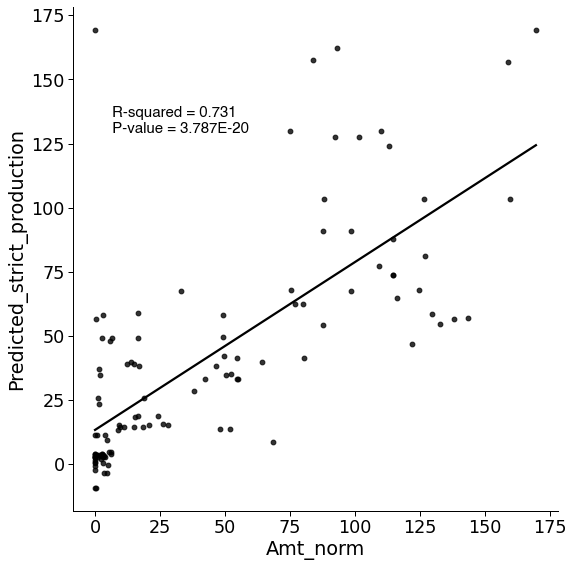

In [17]:
correlation_plot(predicted_vs_sampled,"Amt_norm","Predicted_strict_production")

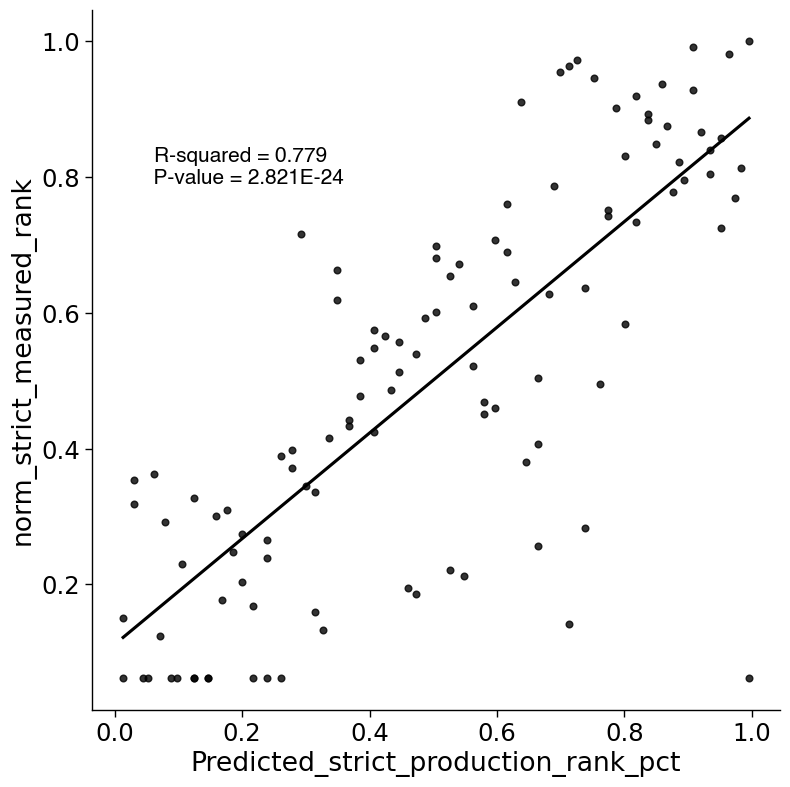

In [18]:
correlation_plot(predicted_vs_sampled,"Predicted_strict_production_rank_pct","norm_strict_measured_rank")

### 1.3 Merging the dataframes for updating the model 

In [19]:
first_input_for_ml = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/input_to_ml/first_round/input_for_ml_1st_iteration_all_analytics.csv')
second_input_for_ml = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/input_to_ml/second_round/input_for_ml_2nd_iteration_all_analytics.csv')
second_input_for_ml.columns = ['Line_name', '0','1','2','3','Amt_norm']

We can add the first dataframe to the second. See below: 

In [27]:
new_input_for_ml = pd.concat([first_input_for_ml, second_input_for_ml])
new_input_for_ml.columns = ['Line_name', '0','1','2','3','Amt_norm']

new_input_for_ml

,Line_name,0,1,2,3,Amt_norm
0,yp49_A01,1,2,5,1,0.922793
1,yp49_C01,1,2,5,9,0.509123
2,yp49_D01,2,4,7,3,0.166871
3,yp49_E01,2,1,5,7,0.327489
4,yp49_F01,3,3,6,1,25.060934
...,...,...,...,...,...,...
124,yp54_A04,4,1,6,1,15.322951
125,yp54_C04,5,2,6,3,94.318358
126,yp54_C09,3,1,6,3,46.469517
127,yp54_D12,5,1,6,6,3.718051


### 1.2 Update dataframe Change 

In [21]:
df_test = h2o.H2OFrame(pd.concat([new_input_for_ml], axis='columns'))
df_test.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Rows:296
Cols:6




,Line_name,0,1,2,3,Amt_norm
type,string,int,int,int,int,real
mins,NaN,1.0,1.0,5.0,1.0,0.0
mean,NaN,4.773648648648648,2.1452702702702697,6.135135135135135,4.750000000000002,28.17229832409186
maxs,NaN,8.0,4.0,8.0,10.0,245.03427469317091
sigma,NaN,1.946604570553522,1.11500304533806,1.0554051268004105,2.5930153901508812,44.45848009052246
zeros,0,0,0,0,0,72
missing,0,0,0,0,0,0
0,yp53_A01,4.0,1.0,5.0,2.0,9.05856182631404
1,yp53_A02,4.0,1.0,5.0,2.0,28.17595190121824
2,yp53_A04,4.0,2.0,5.0,2.0,80.37586179757339


In [22]:
# Since the data is categorical we need to make it from numerical to categorical 
df_test['0']= df_test['0'].asfactor()
df_test['1']= df_test['1'].asfactor()
df_test['2'] = df_test['2'].asfactor()
df_test['3'] = df_test['3'].asfactor()

In [23]:
df_test.describe()

Rows:296
Cols:6




,Line_name,0,1,2,3,Amt_norm
type,string,enum,enum,enum,enum,real
mins,NaN,,,,,0.0
mean,NaN,,,,,28.17229832409186
maxs,NaN,,,,,245.03427469317091
sigma,NaN,,,,,44.45848009052246
zeros,0,,,,,72
missing,0,0,0,0,0,0
0,yp53_A01,4,1,5,2,9.05856182631404
1,yp53_A02,4,1,5,2,28.17595190121824
2,yp53_A04,4,2,5,2,80.37586179757339


Set some arguments for the autoML. 


Important here is that we dont split the dataset but rather keep the cross-validation validate a model internally, i.e., estimate the model performance without having to sacrifice a validation split. See: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html


## 2 RUN automl

Here we are defining the autoML object and after we can train it

In [ ]:
# Select the columns we want to train on
feature_cols = ['0', '1', '2', '3']

# Initialize H2O autoML class
AutoML = H2OAutoML(
    max_runtime_secs=0,  # 1 hour =int(3600 * 1) , if unlimited time is wanted then set this to zero = 0
    max_models=None,  # None =  no limit
    nfolds=10,         # number of folds for k-fold cross-validation (nfolds=0 disables cross-validation)
    seed=1,            # Reproducibility
    sort_metric = "MAE",
    keep_cross_validation_predictions=True 
)

Train a model based on the target and the df. 

In [ ]:
%%time

AutoML.train(
     x=feature_cols,
     y='Amt_norm',
     training_frame=df_test,
 )


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
CPU times: user 36.3 s, sys: 2.88 s, total: 39.2 s
Wall time: 59min 17s
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_lr_search_selection_AutoML_1_20221216_91503_select_grid_model_3


Model Summary: 


,,number_of_trees
0,,156.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 421.29486557698954
RMSE: 20.525468705415463
MAE: 9.148834070707577
RMSLE: NaN
Mean Residual Deviance: 421.29486557698954

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 619.2601551707306
RMSE: 24.88493831960872
MAE: 12.522050341403244
RMSLE: NaN
Mean Residual Deviance: 619.2601551707306

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,12.509687,2.744713,14.918649,12.083114,12.719765,16.045069,7.423237,15.527604,14.125184,9.589990,11.771118,10.893149
1,mean_residual_deviance,619.130000,331.369900,637.066100,431.422670,479.545800,1421.226300,165.851230,618.189450,826.546260,520.081850,647.600040,443.770450
2,mse,619.130000,331.369900,637.066100,431.422670,479.545800,1421.226300,165.851230,618.189450,826.546260,520.081850,647.600040,443.770450
3,r2,0.673519,0.179883,0.568123,0.825567,0.735960,0.611876,0.910472,0.735709,0.709419,0.576398,0.268307,0.793362
4,residual_deviance,619.130000,331.369900,637.066100,431.422670,479.545800,1421.226300,165.851230,618.189450,826.546260,520.081850,647.600040,443.770450
5,rmse,24.141918,6.350661,25.240170,20.770716,21.898535,37.699154,12.878324,24.863415,28.749718,22.805304,25.447987,21.065860
6,rmsle,0.861245,0.246143,1.285108,0.771690,0.647718,0.771036,NaN,NaN,NaN,NaN,NaN,0.830671



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-12-16 10:11:26,2.589 sec,0.0,54.244559,28.879174,2942.472227
1,,2022-12-16 10:11:26,2.598 sec,15.0,38.779313,19.568256,1503.835114
2,,2022-12-16 10:11:26,2.607 sec,30.0,31.253069,15.748491,976.754308
3,,2022-12-16 10:11:26,2.616 sec,45.0,27.412432,13.570354,751.441424
4,,2022-12-16 10:11:26,2.627 sec,60.0,25.077883,12.122273,628.900197
5,,2022-12-16 10:11:26,2.638 sec,75.0,23.538747,11.137741,554.072613
6,,2022-12-16 10:11:26,2.650 sec,90.0,22.567410,10.493061,509.287974
7,,2022-12-16 10:11:26,2.662 sec,105.0,21.849792,10.001497,477.413419
8,,2022-12-16 10:11:26,2.676 sec,120.0,21.345264,9.690114,455.620301
9,,2022-12-16 10:11:26,2.691 sec,135.0,20.964273,9.441597,439.500730



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,1.2,209357.968750,1.000000,0.171633
1,3.7,143852.390625,0.687112,0.117931
2,3.6,137481.437500,0.656681,0.112708
3,2.7,96753.203125,0.462142,0.079319
4,0.5,87002.945312,0.415570,0.071326
5,1.4,82930.289062,0.396117,0.067987
6,0.1,82312.304688,0.393165,0.067480
7,1.3,78622.312500,0.375540,0.064455
8,2.8,62086.320312,0.296556,0.050899
9,0.4,33448.929688,0.159769,0.027422



See the whole table with table.as_data_frame()


In [ ]:
print('DOOOOOOONE')

DOOOOOOONE


## 3. Processing model


In [ ]:
# saving the models
leaderboard = AutoML.leaderboard
model_ids = list(leaderboard['model_id'].as_data_frame().iloc[:,0])

out_path = 'ConStrain_on_google_colab/data/09-AutoML/leaderboards/second_round'

for m_id in model_ids:
     mdl = h2o.get_model(m_id)
     h2o.save_model(model=mdl, path=out_path, force=True)


In [ ]:
len(model_ids)

995

Now we want to extract the best models

In [ ]:
df_from_h2o_object = leaderboard.as_data_frame(use_pandas=True, header=True)
df_from_h2o_object

,model_id,mae,rmse,mse,rmsle,mean_residual_deviance
0,XGBoost_lr_search_selection_AutoML_1_20221216_91503_select_grid_mo...,12.522050,24.884938,619.260155,NaN,619.260155
1,StackedEnsemble_AllModels_5_AutoML_1_20221216_91503,12.545923,24.227289,586.961536,0.920037,586.961536
2,XGBoost_grid_1_AutoML_1_20221216_91503_model_292,12.646375,24.875571,618.794010,NaN,618.794010
3,StackedEnsemble_BestOfFamily_6_AutoML_1_20221216_91503,12.678041,24.218975,586.558772,NaN,586.558772
4,XGBoost_grid_1_AutoML_1_20221216_91503_model_165,12.727607,25.350302,642.637824,NaN,642.637824
...,...,...,...,...,...,...
990,GBM_grid_1_AutoML_1_20221216_91503_model_14,29.301669,40.992241,1680.363816,NaN,1680.363816
991,DeepLearning_grid_2_AutoML_1_20221216_91503_model_10,29.514576,38.820331,1507.018128,NaN,1507.018128
992,GBM_grid_1_AutoML_1_20221216_91503_model_27,29.516332,40.678130,1654.710260,NaN,1654.710260
993,GBM_grid_1_AutoML_1_20221216_91503_model_19,29.725629,41.134269,1692.028093,NaN,1692.028093


### 3.1 Saving the best model

In [ ]:
best_model = AutoML.get_best_model()
best_model

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_lr_search_selection_AutoML_1_20221216_91503_select_grid_model_3


Model Summary: 


,,number_of_trees
0,,156.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 421.29486557698954
RMSE: 20.525468705415463
MAE: 9.148834070707577
RMSLE: NaN
Mean Residual Deviance: 421.29486557698954

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 619.2601551707306
RMSE: 24.88493831960872
MAE: 12.522050341403244
RMSLE: NaN
Mean Residual Deviance: 619.2601551707306

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,12.509687,2.744713,14.918649,12.083114,12.719765,16.045069,7.423237,15.527604,14.125184,9.589990,11.771118,10.893149
1,mean_residual_deviance,619.130000,331.369900,637.066100,431.422670,479.545800,1421.226300,165.851230,618.189450,826.546260,520.081850,647.600040,443.770450
2,mse,619.130000,331.369900,637.066100,431.422670,479.545800,1421.226300,165.851230,618.189450,826.546260,520.081850,647.600040,443.770450
3,r2,0.673519,0.179883,0.568123,0.825567,0.735960,0.611876,0.910472,0.735709,0.709419,0.576398,0.268307,0.793362
4,residual_deviance,619.130000,331.369900,637.066100,431.422670,479.545800,1421.226300,165.851230,618.189450,826.546260,520.081850,647.600040,443.770450
5,rmse,24.141918,6.350661,25.240170,20.770716,21.898535,37.699154,12.878324,24.863415,28.749718,22.805304,25.447987,21.065860
6,rmsle,0.861245,0.246143,1.285108,0.771690,0.647718,0.771036,NaN,NaN,NaN,NaN,NaN,0.830671



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-12-16 10:11:26,2.589 sec,0.0,54.244559,28.879174,2942.472227
1,,2022-12-16 10:11:26,2.598 sec,15.0,38.779313,19.568256,1503.835114
2,,2022-12-16 10:11:26,2.607 sec,30.0,31.253069,15.748491,976.754308
3,,2022-12-16 10:11:26,2.616 sec,45.0,27.412432,13.570354,751.441424
4,,2022-12-16 10:11:26,2.627 sec,60.0,25.077883,12.122273,628.900197
5,,2022-12-16 10:11:26,2.638 sec,75.0,23.538747,11.137741,554.072613
6,,2022-12-16 10:11:26,2.650 sec,90.0,22.567410,10.493061,509.287974
7,,2022-12-16 10:11:26,2.662 sec,105.0,21.849792,10.001497,477.413419
8,,2022-12-16 10:11:26,2.676 sec,120.0,21.345264,9.690114,455.620301
9,,2022-12-16 10:11:26,2.691 sec,135.0,20.964273,9.441597,439.500730



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,1.2,209357.968750,1.000000,0.171633
1,3.7,143852.390625,0.687112,0.117931
2,3.6,137481.437500,0.656681,0.112708
3,2.7,96753.203125,0.462142,0.079319
4,0.5,87002.945312,0.415570,0.071326
5,1.4,82930.289062,0.396117,0.067987
6,0.1,82312.304688,0.393165,0.067480
7,1.3,78622.312500,0.375540,0.064455
8,2.8,62086.320312,0.296556,0.050899
9,0.4,33448.929688,0.159769,0.027422



See the whole table with table.as_data_frame()


In [ ]:
model_path = h2o.save_model(model=best_model, path="ConStrain_on_google_colab/data/09-AutoML/best_models/second_round/", force=True)

### 3.2 Exporting the leaderboard

In [ ]:
# saving the leaderboard
import os
h2o.export_file(leaderboard, os.path.join(out_path, 'aml_leaderboard.h2o'), force=True)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


### 3.3 Importing the leaderboard

In [ ]:
models_path = 'ConStrain_on_google_colab/data/09-AutoML/leaderboards/second_round/'

lb = h2o.import_file(path=os.path.join(models_path, "aml_leaderboard.h2o"))
lb

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


model_id,mae,rmse,mse,rmsle,mean_residual_deviance
XGBoost_lr_search_selection_AutoML_1_20221216_91503_select_grid_model_3,12.5221,24.8849,619.26,nan,619.26
StackedEnsemble_AllModels_5_AutoML_1_20221216_91503,12.5459,24.2273,586.962,0.920037,586.962
XGBoost_grid_1_AutoML_1_20221216_91503_model_292,12.6464,24.8756,618.794,nan,618.794
StackedEnsemble_BestOfFamily_6_AutoML_1_20221216_91503,12.678,24.219,586.559,nan,586.559
XGBoost_grid_1_AutoML_1_20221216_91503_model_165,12.7276,25.3503,642.638,nan,642.638
StackedEnsemble_BestOfFamily_4_AutoML_1_20221216_91503,12.7788,24.2906,590.034,nan,590.034
StackedEnsemble_BestOfFamily_5_AutoML_1_20221216_91503,12.8471,25.1051,630.265,nan,630.265
XGBoost_grid_1_AutoML_1_20221216_91503_model_131,13.0556,25.1855,634.31,nan,634.31
StackedEnsemble_AllModels_6_AutoML_1_20221216_91503,13.4384,24.8997,619.997,nan,619.997
DeepLearning_grid_1_AutoML_1_20221216_91503_model_38,13.5549,24.3542,593.127,nan,593.127


## 4. Importing the best model

In [ ]:
best_model = h2o.load_model("ConStrain_on_google_colab/data/09-AutoML/best_models/second_round/"+lb[0,0])
my_local_model = h2o.download_model(best_model, path="ConStrain_on_google_colab/data/09-AutoML/best_models/second_round/")
uploaded_model = h2o.upload_model(my_local_model)


In [ ]:
cv = best_model.cross_validation_holdout_predictions()
type(cv)

h2o.frame.H2OFrame

### 4.1 Investigate model

In [ ]:
best_model.cross_validation_holdout_predictions()

predict
2.62505
1.36812
0.25857
0.243338
-3.43682
26.4084
0.889619
0.221797
0.981092
0.470854


Get the cross validation predictions

In [ ]:
# This is where list of cv preds are stored (one element per fold):
cross_validation_holdout_predictions = best_model.cross_validation_holdout_predictions()
print(cross_validation_holdout_predictions)
print(len(cross_validation_holdout_predictions))

predict
2.62505
1.36812
0.25857
0.243338
-3.43682
26.4084
0.889619
0.221797
0.981092
0.470854



296


In [ ]:
cv_fram = cross_validation_holdout_predictions.as_data_frame()
cv_fram

,predict
0,2.625047
1,1.368123
2,0.258570
3,0.243338
4,-3.436822
...,...
291,19.900133
292,115.835068
293,41.059017
294,0.321124


In [ ]:
# However you most likely want a single-column frame including all cv preds
cross_validation_predictions = best_model.cross_validation_predictions()
print(len(cross_validation_predictions))

10


In [ ]:
as_data_frame_df_test = df_test.as_data_frame()
as_data_frame_CV_predictions = cross_validation_holdout_predictions.as_data_frame()

In [ ]:
df3 = pd.merge(as_data_frame_df_test, as_data_frame_CV_predictions, left_index=True, right_index=True)
df3 = df3.sort_values(by= 'Amt_norm', ascending= False)
df3 = df3.reset_index()
df3['ranked_pct'] = df3['Amt_norm'].rank(pct= True)
df3['ranked_pct_predicted'] = df3['predict'].rank(pct= True)
df3

,index,Line_name,0,1,2,3,Amt_norm,predict,ranked_pct,ranked_pct_predicted
0,73,yp50_D03,5,2,6,3,277.307816,96.999344,1.000000,0.918919
1,75,yp50_G03,6,2,6,5,176.917201,111.369507,0.996622,0.969595
2,205,yp53_D09,5,2,6,5,169.631396,100.853073,0.993243,0.939189
3,86,yp50_E05,5,1,6,8,163.352037,75.240669,0.989865,0.814189
4,193,yp53_C06,6,2,6,4,159.517718,114.271469,0.986486,0.976351
...,...,...,...,...,...,...,...,...,...,...
291,92,yp50_G06,6,4,6,6,0.000000,0.126829,0.123311,0.131757
292,95,yp50_B07,4,3,8,7,0.000000,0.541050,0.123311,0.263514
293,99,yp50_G07,6,1,5,7,0.000000,1.518117,0.123311,0.381757
294,101,yp50_B08,4,4,5,7,0.000000,0.131664,0.123311,0.138514


In [ ]:
len(df3)

296

In [ ]:
from constrain.plotting.plotting import bar_plot_w_hue

In [ ]:
%%capture
# initialize
ds1 = df3[['Line_name', 'Amt_norm']]
ds1.columns = ['Line_name', 'strict']
ds2 = df3[['Line_name', 'predict']]
ds2.columns = ['Line_name', 'strict']

# add category
ds2['category'] = 'Predicted'
ds1['category'] = 'Strictosidine'
dss = pd.concat([ds1, ds2])

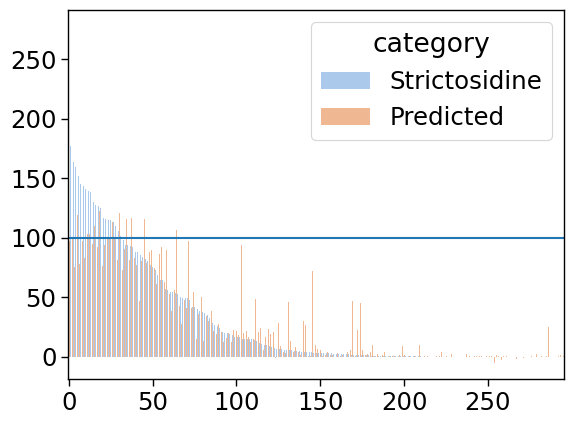

In [ ]:
bar_plot_w_hue(dss, 'Line_name', 'strict', path = 'ConStrain_on_google_colab/data/10-plots/11_2_LEARN_Data_analysis/Bar_plot_prediction_vs_the_sampled_library')

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_10626/4051055021.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds2['category'] = 'Predicted'
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_10626/4051055021.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds1['category'] = 'Strictosidine'


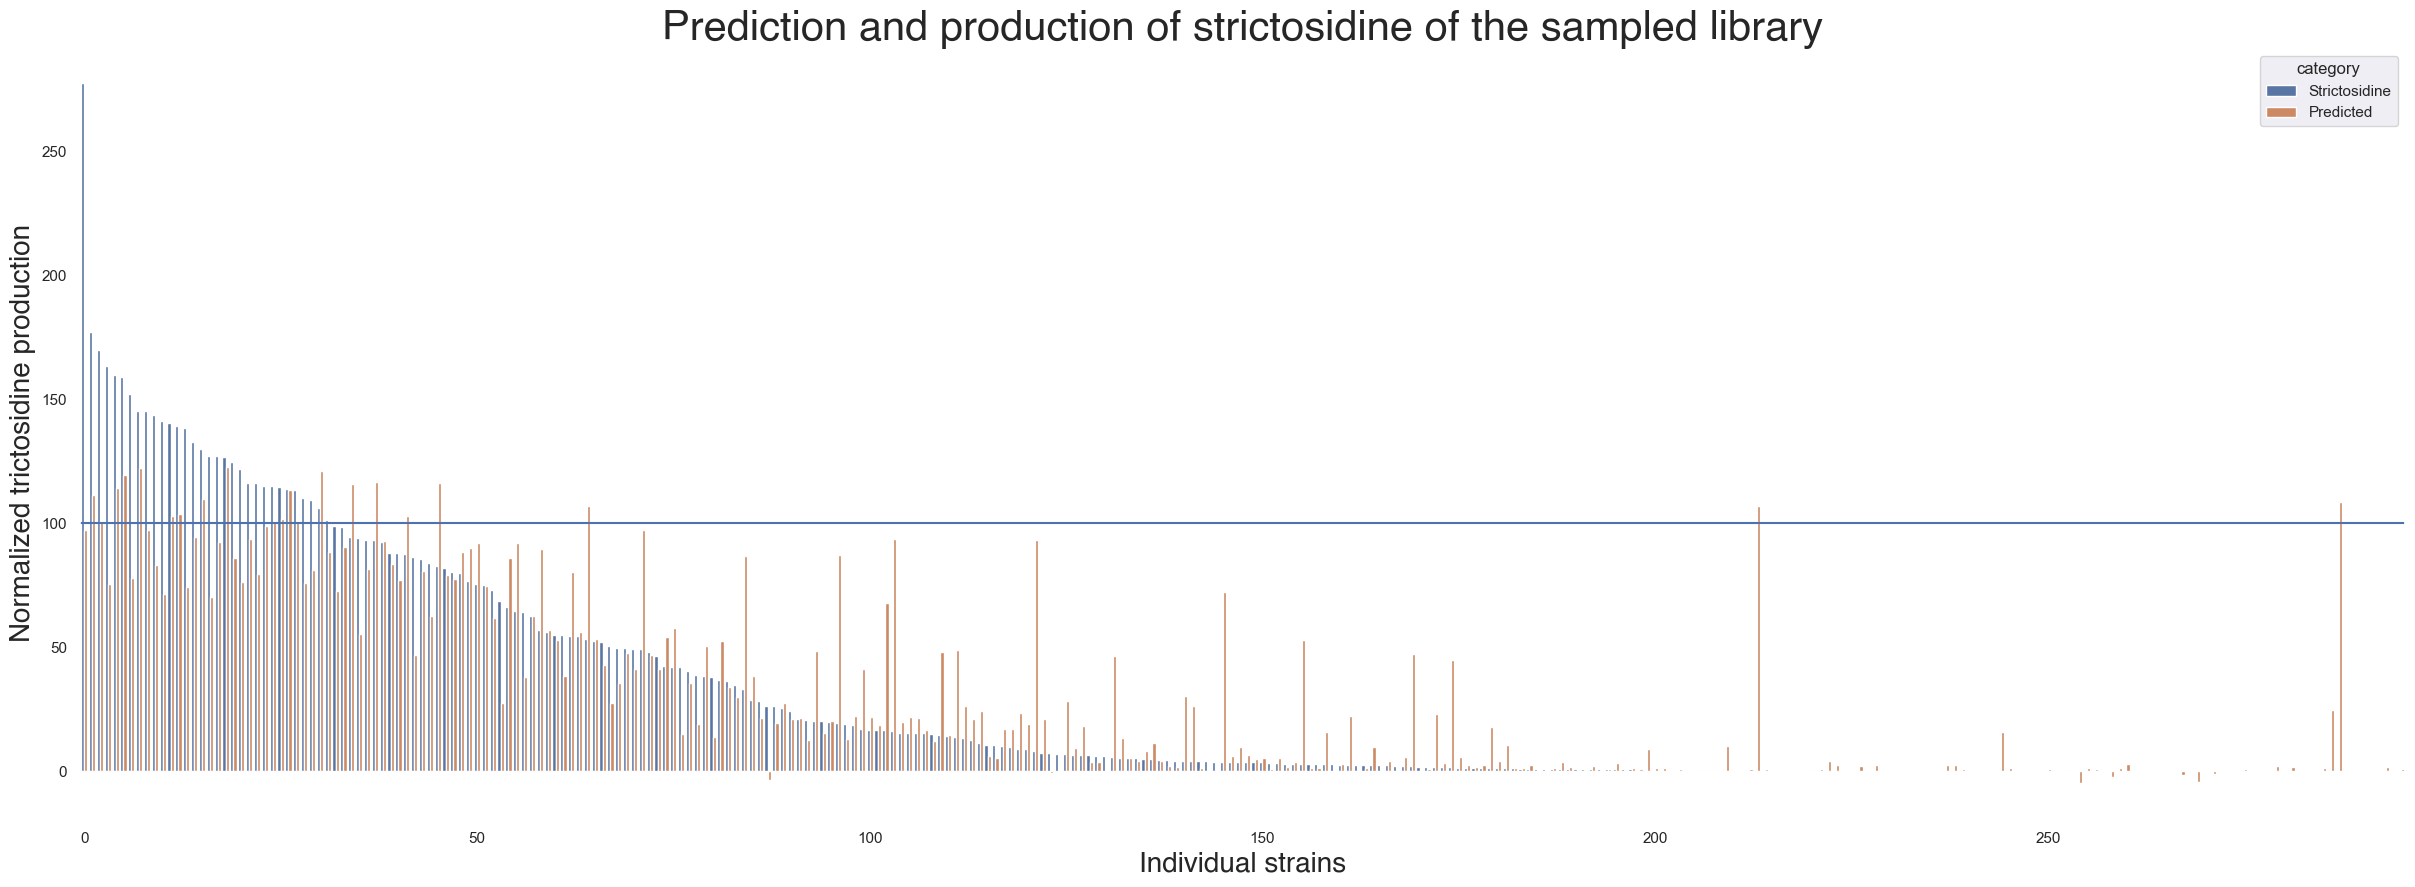

In [ ]:
sns.set(rc = {'figure.figsize':(30,10) })

# initialize
ds1 = df3[['Line_name', 'Amt_norm']]
ds1.columns = ['Line_name', 'strict']

ds2 = df3[['Line_name', 'predict']]
ds2.columns = ['Line_name', 'strict']


ds2['category'] = 'Predicted'
ds1['category'] = 'Strictosidine'
dss = pd.concat([ds1, ds2])

ax = sns.barplot(x='Line_name', y='strict', hue='category', data=dss)

ax = plt.gca()
ax.set_xlabel('Individual strains', size = 20, fontname='Helvetica')
ax.set_ylabel('Normalized trictosidine production', size = 20, fontname='Helvetica')
ax.set_title('Prediction and production of strictosidine of the sampled library', size = 30, fontname='Helvetica')

# white background
ax.set_facecolor("white")

plt.xscale('linear') 

# normalized line
ax.axhline(100)


#ax.add_line
name = 'Strictosidine and predicted values for all genotypes samples (dbtl1+2)'
plt.savefig('ConStrain_on_google_colab/data/10-plots/11_2_LEARN_Data_analysis/'+name+'.svg',format = 'SVG',  dpi = 120)


None

### CV-Holdout predictions vs measured

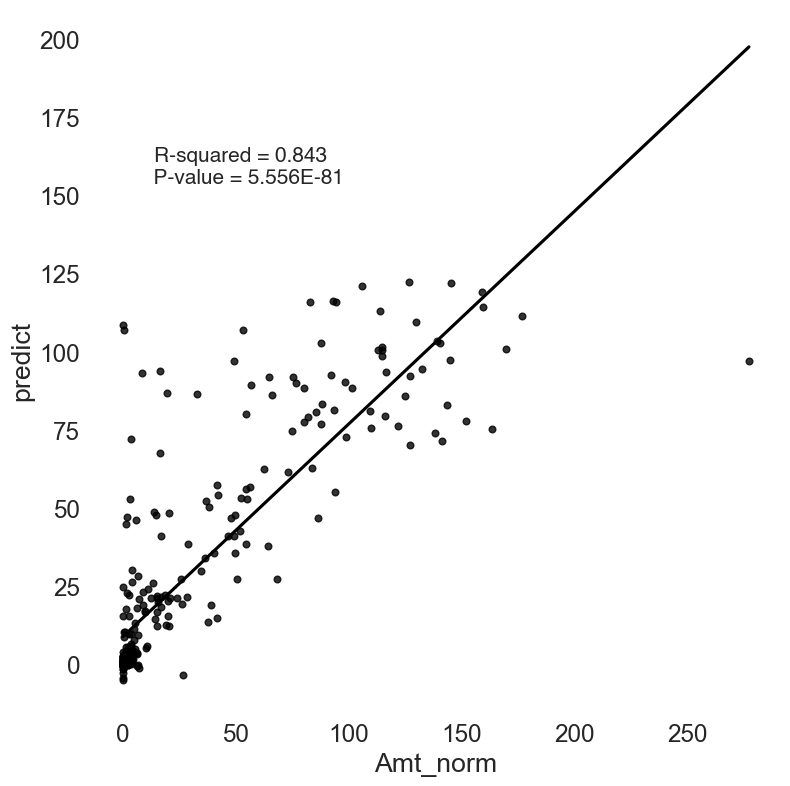

In [ ]:
correlation_plot(df3,"Amt_norm","predict")

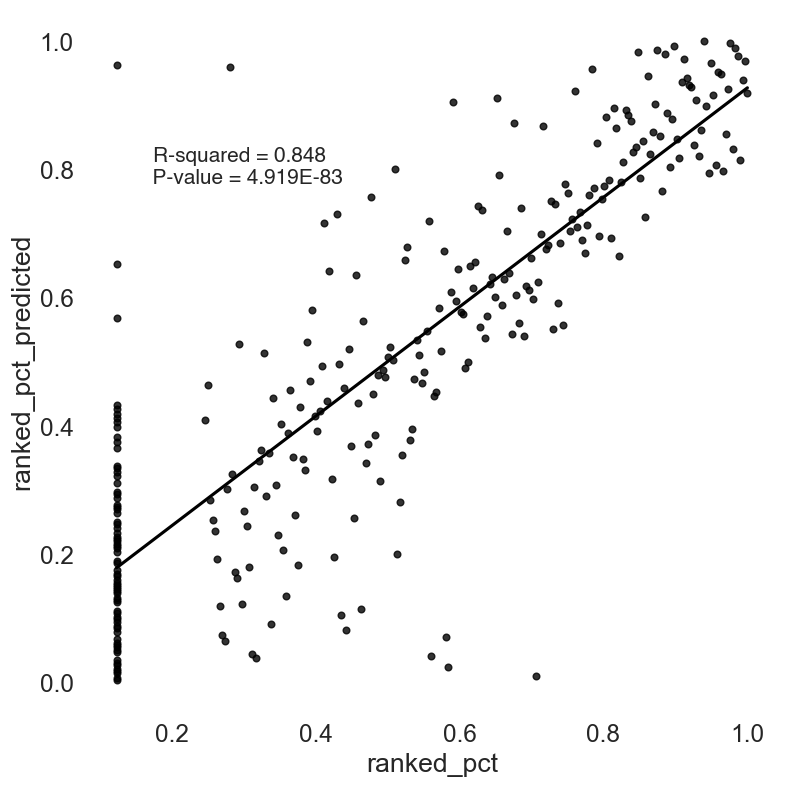

In [ ]:
correlation_plot(df3,"ranked_pct","ranked_pct_predicted")

### 4.3 Find predicted genotypes

In [ ]:
import numpy as np

In [ ]:
all_genotypes = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/genotypes_for_ml/remaining_genotypes_after_first_iteration.csv',)
all_genotypes =all_genotypes[['0','1','2','3']]
all_genotypes

,0,1,2,3
0,1,1,5,1
1,1,1,5,2
2,1,1,5,4
3,1,1,5,5
4,1,1,5,7
...,...,...,...,...
1117,8,4,8,6
1118,8,4,8,7
1119,8,4,8,8
1120,8,4,8,9


In [ ]:
all_genotypes_df = h2o.H2OFrame(pd.concat([all_genotypes], axis='columns'))
all_genotypes_df

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


0,1,2,3
1,1,5,1
1,1,5,2
1,1,5,4
1,1,5,5
1,1,5,7
1,1,5,8
1,1,5,9
1,1,6,1
1,1,6,2
1,1,6,3


In [ ]:
#merge_ = pd.merge(new_input_for_ml,all_genotypes, on= ['0','1','2','3'])
#merge_
new_input_for_ml = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/input_to_ml/second_round/input_for_ml_2nd_iteration_all_analytics.csv',  index_col=False)

input_fixed = new_input_for_ml[['0','1','2','3']]
input_fixed

,0,1,2,3
0,4,1,5,2
1,4,1,5,2
2,4,2,5,2
3,5,1,5,2
4,5,1,5,2
...,...,...,...,...
122,7,2,5,7
123,7,2,5,7
124,7,2,6,7
125,4,2,5,2


### 4.4 Getting rid of the genotypes we have already tested:

In [ ]:
df_diff = all_genotypes[~all_genotypes.apply(tuple,1).isin(input_fixed.apply(tuple,1))]
df_diff.to_csv('ConStrain_on_google_colab/data/09-AutoML/genotypes_for_ml/remaining_genotypes_after_second_iteration.csv')
df_diff

,0,1,2,3
0,1,1,5,1
1,1,1,5,2
2,1,1,5,4
3,1,1,5,5
4,1,1,5,7
...,...,...,...,...
1117,8,4,8,6
1118,8,4,8,7
1119,8,4,8,8
1120,8,4,8,9


In [ ]:
# make the diff into a df 
all_genotypes_df = h2o.H2OFrame(pd.concat([df_diff], axis='columns'))
all_genotypes_df['0']= all_genotypes_df['0'].asfactor()
all_genotypes_df['1']= all_genotypes_df['1'].asfactor()
all_genotypes_df['2'] = all_genotypes_df['2'].asfactor()
all_genotypes_df['3'] = all_genotypes_df['3'].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
predicted = best_model.predict(all_genotypes_df)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [ ]:
len(predicted)

1049

In [ ]:
predicted_norm = predicted.as_data_frame()
predicted_norm.head()

,predict
0,1.381696
1,0.937428
2,1.708319
3,1.602157
4,0.384537


In [ ]:
# making predictions into a list
predicted_list = predicted_norm['predict'].values.tolist()

# Adding predictions to our dataframe
df_diff['predicted_norm_strict'] = predicted_list

# Sorting the dataframe
predicted_merged_sorted = df_diff.sort_values('predicted_norm_strict', ascending=False)
predicted_merged_sorted

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_10626/105107836.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['predicted_norm_strict'] = predicted_list


,0,1,2,3,predicted_norm_strict
614,5,2,6,8,125.507683
610,5,2,6,4,123.953873
748,6,2,6,2,121.058182
605,5,2,5,8,119.939774
602,5,2,5,4,119.415718
...,...,...,...,...,...
862,7,1,7,1,-5.890666
869,7,1,7,9,-6.474187
865,7,1,7,4,-6.538404
864,7,1,7,3,-6.681534


If we want the names on the genotypes we can do the following: 

In [ ]:
g8h_list_of_index = ["Cacu", "Opum","Cro","Vmin","Smus","Rsep","Oeu","Ccal"]
cpr_list_of_index = ["Cro", "Aan","Ara","Clo","Rse","Ahu","Ani","Cac","Oeu","Cpo"]
promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

g8h_genotype = []
cpr_genotype = []

pg8h_genotype = []
pcpr_genotype = []

predicted_list = []
# adding index of genotypes to individual rows 
for index, row in predicted_merged_sorted.iterrows():
    g8h_genotype.append(g8h_list_of_index[int(row['0'])-1])
    cpr_genotype.append(cpr_list_of_index[int(row['3'])-1])
    pg8h_genotype.append(promoters[int(row['1'])-1])
    pcpr_genotype.append(promoters[int(row['2'])-1])
    predicted_list.append(row['predicted_norm_strict'])
    
    
list_of_lists = [g8h_genotype,pg8h_genotype,pcpr_genotype, cpr_genotype, predicted_list  ]

Save the data to a csv 

## 5. Top 20 predicted producers

In [ ]:
df_with_genotypes = pd.DataFrame(list_of_lists )
df_with_genotypes = df_with_genotypes.T
df_with_genotypes.columns = ['G8H', 'pG8H', 'pCPR', 'CPR', 'Predicted_strict_production']
df_with_genotypes.head(20)

,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,Smus,ENO2,TPI1,Cac,125.507683
1,Smus,ENO2,TPI1,Clo,123.953873
2,Rsep,ENO2,TPI1,Aan,121.058182
3,Smus,ENO2,CCW12,Cac,119.939774
4,Smus,ENO2,CCW12,Clo,119.415718
5,Smus,ENO2,CCW12,Aan,119.15493
6,Rsep,ENO2,TPI1,Cac,118.785843
7,Smus,ENO2,CCW12,Ara,113.73101
8,Rsep,ENO2,CCW12,Rse,113.126915
9,Rsep,ENO2,CCW12,Cac,111.33947


Saving the predictions

In [ ]:
#Top20
df_with_genotypes_top20 = df_with_genotypes[:20]
df_with_genotypes_top20.to_csv('ConStrain_on_google_colab/data/09-AutoML/Top20_predictions/second_round/top20_ML_predicted_after_second_DBTL_2nd_analytics_1.csv')

# All predictions
df_with_genotypes.to_csv('ConStrain_on_google_colab/data/09-AutoML/all_predictions/second_round/top_ML_predicted_after_second_DBTL_2nd_analytics.csv', index=False)

In [ ]:
from constrain.plotting.plotting import bar_plot
bar_plot

<function constrain.plotting.plotting.bar_plot(x: list, y: list, error_bar: list = None, horisontal_line=True, save_pdf=True, color='white', path='', title=None, x_label=None, y_label=None) -> None>

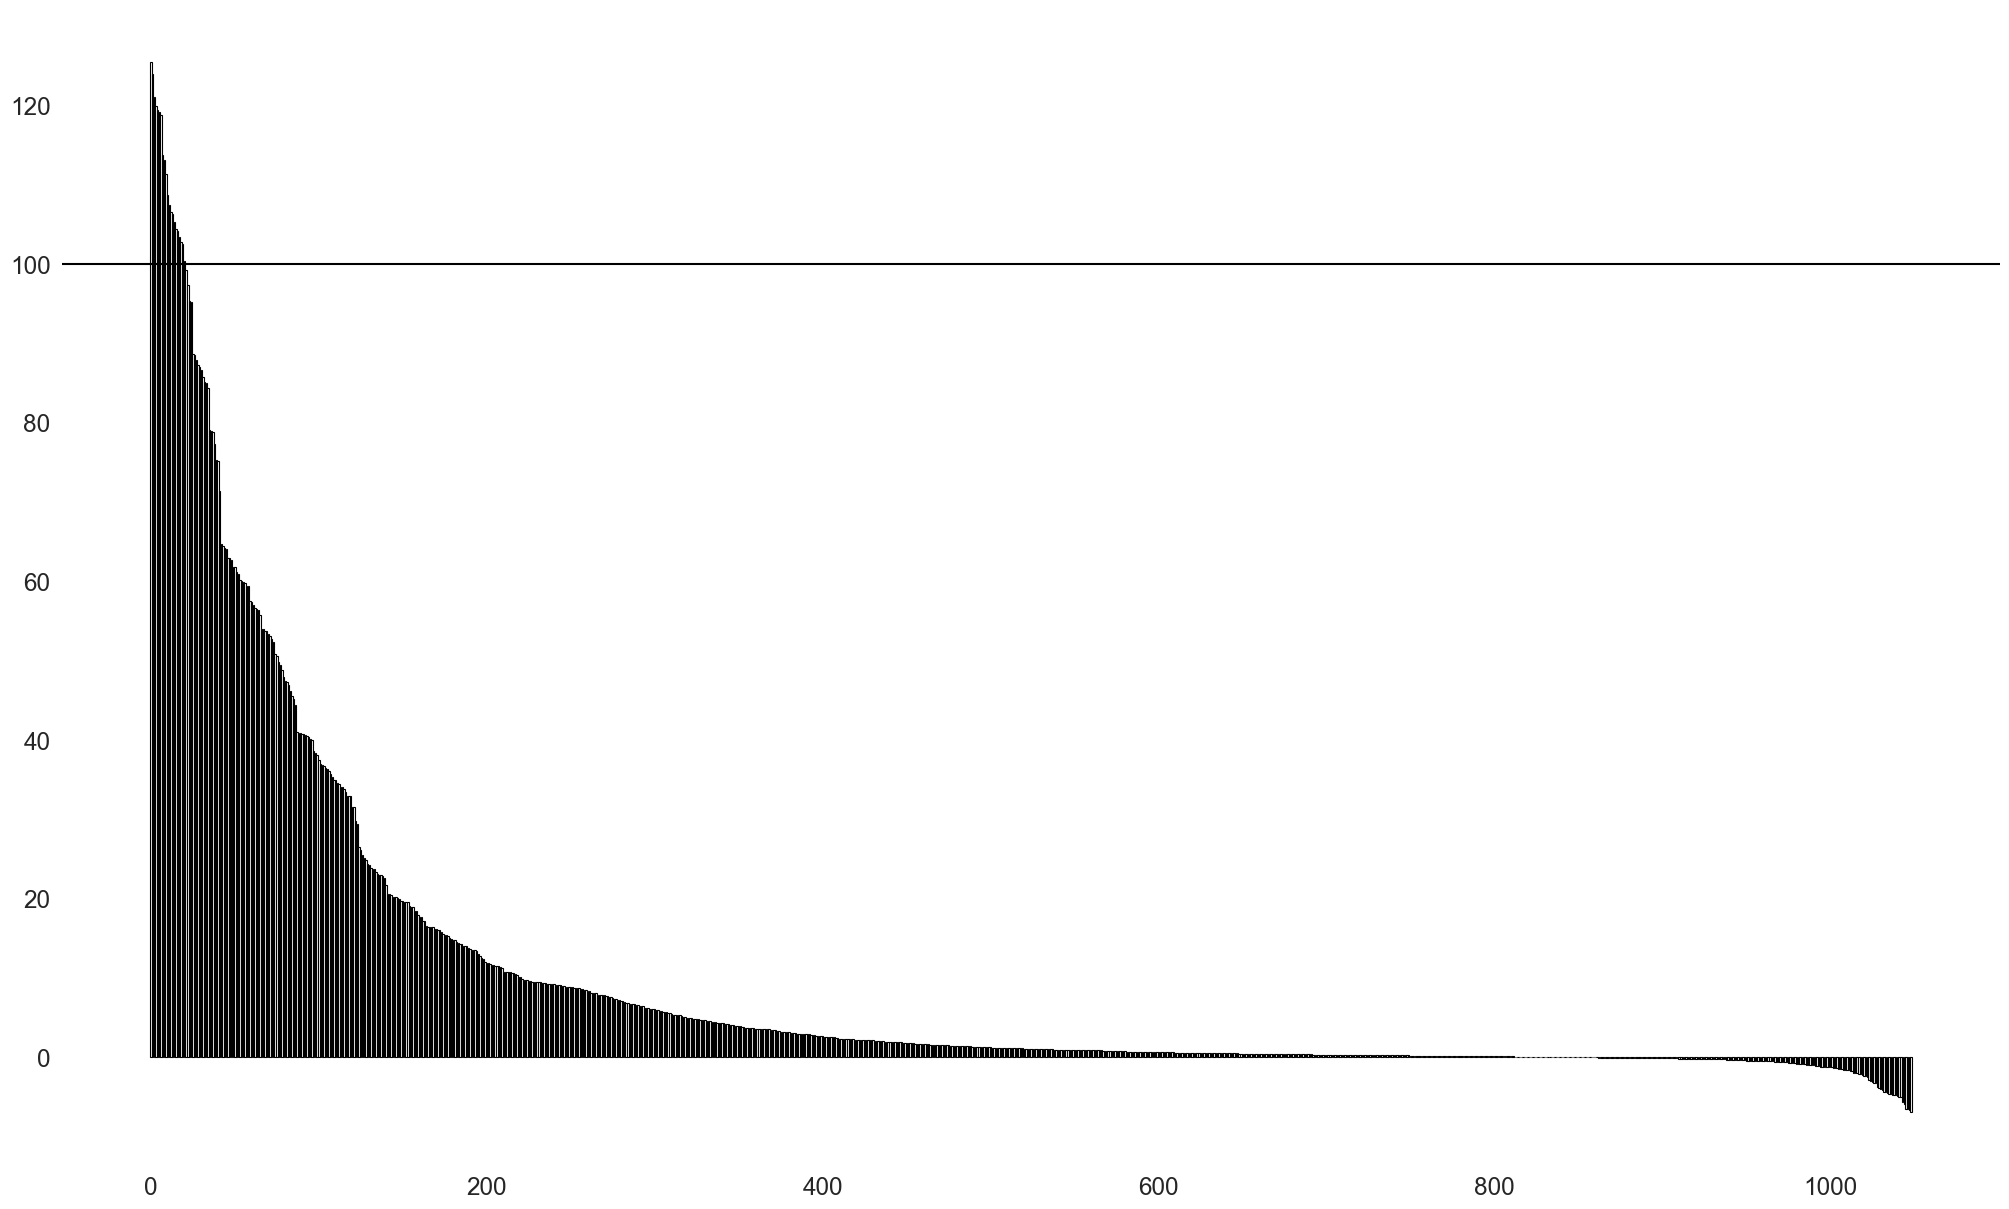

In [ ]:
x = list(df_with_genotypes.index)
y = list(df_with_genotypes['Predicted_strict_production'])

bar_plot(x, y)

In [ ]:
df_with_genotypes = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/top20_ML_predicted_after_second_DBTL_2nd_analytics.csv')

In [ ]:
df_with_genotypes['names'] = df_with_genotypes['G8H']+'-' +df_with_genotypes['pG8H']+ '_'+ df_with_genotypes['pCPR']+'_'+df_with_genotypes['CPR']

In [ ]:
df_with_genotypes

,Unnamed: 0,G8H,pG8H,pCPR,CPR,Predicted_strict_production,names
0,0,Smus,ENO2,TPI1,Cac,125.507683,Smus-ENO2_TPI1_Cac
1,1,Smus,ENO2,TPI1,Clo,123.953873,Smus-ENO2_TPI1_Clo
2,2,Rsep,ENO2,TPI1,Aan,121.058182,Rsep-ENO2_TPI1_Aan
3,3,Smus,ENO2,CCW12,Cac,119.939774,Smus-ENO2_CCW12_Cac
4,4,Smus,ENO2,CCW12,Clo,119.415718,Smus-ENO2_CCW12_Clo
...,...,...,...,...,...,...,...
1044,1044,Oeu,CYC1,MLS1,Cro,-5.890666,Oeu-CYC1_MLS1_Cro
1045,1045,Oeu,CYC1,MLS1,Oeu,-6.474187,Oeu-CYC1_MLS1_Oeu
1046,1046,Oeu,CYC1,MLS1,Clo,-6.538404,Oeu-CYC1_MLS1_Clo
1047,1047,Oeu,CYC1,MLS1,Ara,-6.681534,Oeu-CYC1_MLS1_Ara


In [ ]:
x_axis = list(df_with_genotypes['names'])[:20][::-1]
y_axis = list(df_with_genotypes['Predicted_strict_production'])[:20][::-1]

In [ ]:
from constrain.plotting.plotting import horisontal_bar_plot

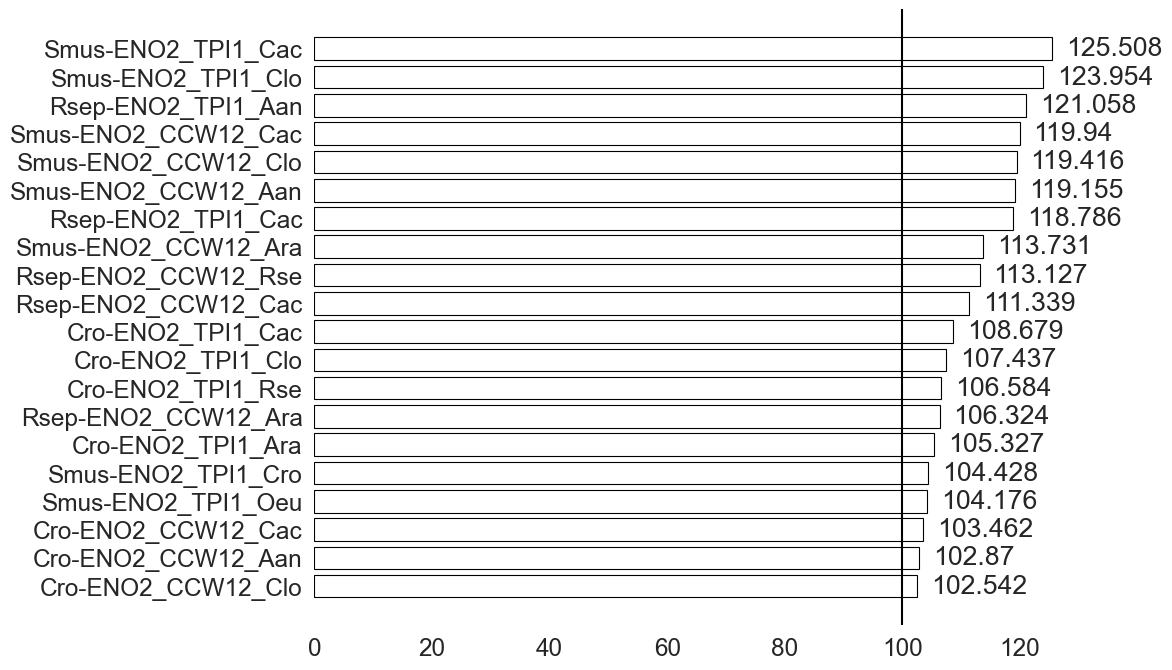

In [ ]:
horisontal_bar_plot(x_axis,y_axis,  path = 'ConStrain_on_google_colab/data/10-plots/11_2_LEARN_Data_analysis/Top20_predicted_strains_ML2', 
                    title = 'Top20 predicted strains DBTL2', 
                   size_height=5, 
                   size_length=10)

### 5.1 How many genotypes are predicted to produce more than the control strain?

In [ ]:
over_100_strict_procduction = df_with_genotypes[df_with_genotypes['Predicted_strict_production'] >= 100 ]
print(f"{len(over_100_strict_procduction)} strains out of {len(df_with_genotypes)} showed production of strictosidine over the normalized value")
print(f"Out of the remaing theoretical space these constittue : {(len(over_100_strict_procduction)/len(df_with_genotypes))*100}%")

21 strains out of 1049 showed production of strictosidine over the normalized value
Out of the remaing theoretical space these constittue : 2.001906577693041%


## 5.2 How does the model predict on the old library i.e. 1121? Do we get the same genotypes? 

In [ ]:
all_genotypes_1121 = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/genotypes_for_ml/remaining_genotypes_after_first_iteration.csv', index_col= False)
all_genotypes =all_genotypes_1121[['0','1','2','3']]
all_genotypes_df = h2o.H2OFrame(pd.concat([all_genotypes], axis='columns'))

# Predict
predicted = best_model.predict(all_genotypes_df)

# make to dataframe
predicted_norm = predicted.as_data_frame()

# making predictions into a list
predicted_list = predicted_norm['predict'].values.tolist()

# Adding predictions to our dataframe
all_genotypes_1121['predicted_norm_strict'] = predicted_list

# Sorting the dataframe
predicted_merged_sorted = all_genotypes_1121.sort_values('predicted_norm_strict', ascending=False)
predicted_merged_sorted.to_csv('ConStrain_on_google_colab/data/09-AutoML/all_predictions/second_round_model_on_old_library/top_predictions_by_second_round_model_on_data_from_the_first_round.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [ ]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]
promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

g8h_genotype = []
cpr_genotype = []

pg8h_genotype = []
pcpr_genotype = []

predicted_list = []
# adding index of genotypes to individual rows 
for index, row in predicted_merged_sorted.iterrows():
    g8h_genotype.append(g8h_list_of_index[int(row['0'])-1])
    cpr_genotype.append(cpr_list_of_index[int(row['3'])-1])
    pg8h_genotype.append(promoters[int(row['1'])-1])
    pcpr_genotype.append(promoters[int(row['2'])-1])
    predicted_list.append(row['predicted_norm_strict'])
    
    
list_of_lists = [g8h_genotype,pg8h_genotype,pcpr_genotype, cpr_genotype, predicted_list  ]

In [ ]:
ML2_recomendations = pd.DataFrame(list_of_lists )
ML2_recomendations = ML2_recomendations.T

ML2_recomendations.columns = ['G8H', 'pG8H', 'pCPR', 'CPR', 'Predicted_strict_production']
ML2_recomendations100 = ML2_recomendations[:100]

In [ ]:
# what it recomended in first round 
ML1_recomendations = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/all_predictions/first_round/top_ML_predicted_after_first_DBTL_merged_analytics.csv')
ML1_recomendations100 = ML1_recomendations[0:100]
ML1_recomendations100['G8H'] = ML1_recomendations100['G8H']+'G8H'
ML1_recomendations100['CPR'] = ML1_recomendations100['CPR']+'CPR'

ML1_recomendations100

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_10626/2198562923.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML1_recomendations100['G8H'] = ML1_recomendations100['G8H']+'G8H'
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_10626/2198562923.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML1_recomendations100['CPR'] = ML1_recomendations100['CPR']+'CPR'


,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,SmusG8H,ENO2,TPI1,CroCPR,226.138557
1,SmusG8H,ENO2,TPI1,CloCPR,210.261962
2,SmusG8H,ENO2,TPI1,CacCPR,205.359575
3,SmusG8H,ENO2,TPI1,AanCPR,204.539731
4,RsepG8H,ENO2,TPI1,CroCPR,193.218189
...,...,...,...,...,...
95,OpumG8H,ENO2,TPI1,RseCPR,44.912977
96,VminG8H,CYC1,TPI1,AanCPR,44.517995
97,SmusG8H,RPL15B,TPI1,CacCPR,44.365785
98,SmusG8H,ENO2,URE2,OeuCPR,44.162532


In [ ]:
ML1_recomendations100 = ML1_recomendations100[['G8H', 'pG8H', 'pCPR', 'CPR']]
ML2_recomendations100 = ML2_recomendations100[['G8H', 'pG8H', 'pCPR', 'CPR']]
ML2_recomendations100

,G8H,pG8H,pCPR,CPR
0,SmusG8H,ENO2,TPI1,AanCPR
1,SmusG8H,ENO2,TPI1,CacCPR
2,SmusG8H,ENO2,TPI1,CloCPR
3,RsepG8H,ENO2,TPI1,AanCPR
4,SmusG8H,ENO2,CCW12,CacCPR
...,...,...,...,...
95,RsepG8H,CYC1,CCW12,CloCPR
96,RsepG8H,CYC1,TPI1,RseCPR
97,SmusG8H,CYC1,CCW12,CroCPR
98,CroG8H,ENO2,URE2,OeuCPR


In [ ]:
comparison = ML1_recomendations100.compare(ML2_recomendations100, keep_shape=True, keep_equal=True)
comparison

G8H             pG8H        pCPR            CPR        
       self    other    self other  self  other    self   other
0   SmusG8H  SmusG8H    ENO2  ENO2  TPI1   TPI1  CroCPR  AanCPR
1   SmusG8H  SmusG8H    ENO2  ENO2  TPI1   TPI1  CloCPR  CacCPR
2   SmusG8H  SmusG8H    ENO2  ENO2  TPI1   TPI1  CacCPR  CloCPR
3   SmusG8H  RsepG8H    ENO2  ENO2  TPI1   TPI1  AanCPR  AanCPR
4   RsepG8H  SmusG8H    ENO2  ENO2  TPI1  CCW12  CroCPR  CacCPR
..      ...      ...     ...   ...   ...    ...     ...     ...
95  OpumG8H  RsepG8H    ENO2  CYC1  TPI1  CCW12  RseCPR  CloCPR
96  VminG8H  RsepG8H    CYC1  CYC1  TPI1   TPI1  AanCPR  RseCPR
97  SmusG8H  SmusG8H  RPL15B  CYC1  TPI1  CCW12  CacCPR  CroCPR
98  SmusG8H   CroG8H    ENO2  ENO2  URE2   URE2  OeuCPR  OeuCPR
99  OpumG8H  VminG8H    ENO2  ENO2  TPI1   URE2  AanCPR  AraCPR

[100 rows x 8 columns]

In [ ]:
comparison.to_csv('ConStrain_on_google_colab/data/09-AutoML/all_predictions/second_round_model_on_old_library/ML1_top_predicted_vs_ML2_top100_predicted.csv')

In [ ]:
difference = pd.concat([ML1_recomendations100,ML2_recomendations100]).drop_duplicates(keep=False)
the_same_rows = len(ML1_recomendations100) -len(difference)

In [ ]:
print(f'The top predictions from the ML model in the second dbtl are share by the first round by {the_same_rows/len(ML1_recomendations100)*100}%')

The top predictions from the ML model in the second dbtl are share by the first round by 62.0%


## Plotting the top predictions 

In [ ]:
from constrain.plotting.plotting import color_range_dict
# importing a range of colors
cpr_color = color_range_dict()['yellow'][::2][::-1]
print(len(cpr_color))
pcpr_color = color_range_dict()['orange'][::6][::-1]
print(len(pcpr_color))
g8H_color= color_range_dict()['blue'][::3][::-1]
print(len(g8H_color))
pg8h_color = color_range_dict()['green'][::5][::-1]
print(len(pg8h_color))

In [ ]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]
pg8h_list_of_index = ["CYC1", "ENO2","PCK1","RPL15B"]
pcpr_list_of_index = ["CCW12", "TPI1","MLS1","URE2"]
all_parts = g8h_list_of_index + pg8h_list_of_index+pcpr_list_of_index+cpr_list_of_index

G8H_color_codes = dict(zip(g8h_list_of_index, g8H_color))
pG8H_color_codes = dict(zip(pg8h_list_of_index, pg8h_color))
pCPR_color_codes = dict(zip(pcpr_list_of_index, pcpr_color))
CPR_color_codes = dict(zip(cpr_list_of_index, cpr_color))

colorDict = dict(G8H_color_codes, **pG8H_color_codes,**pCPR_color_codes, **CPR_color_codes)

In [ ]:
from constrain.plotting.plotting import plot_stacked_barplot

26


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


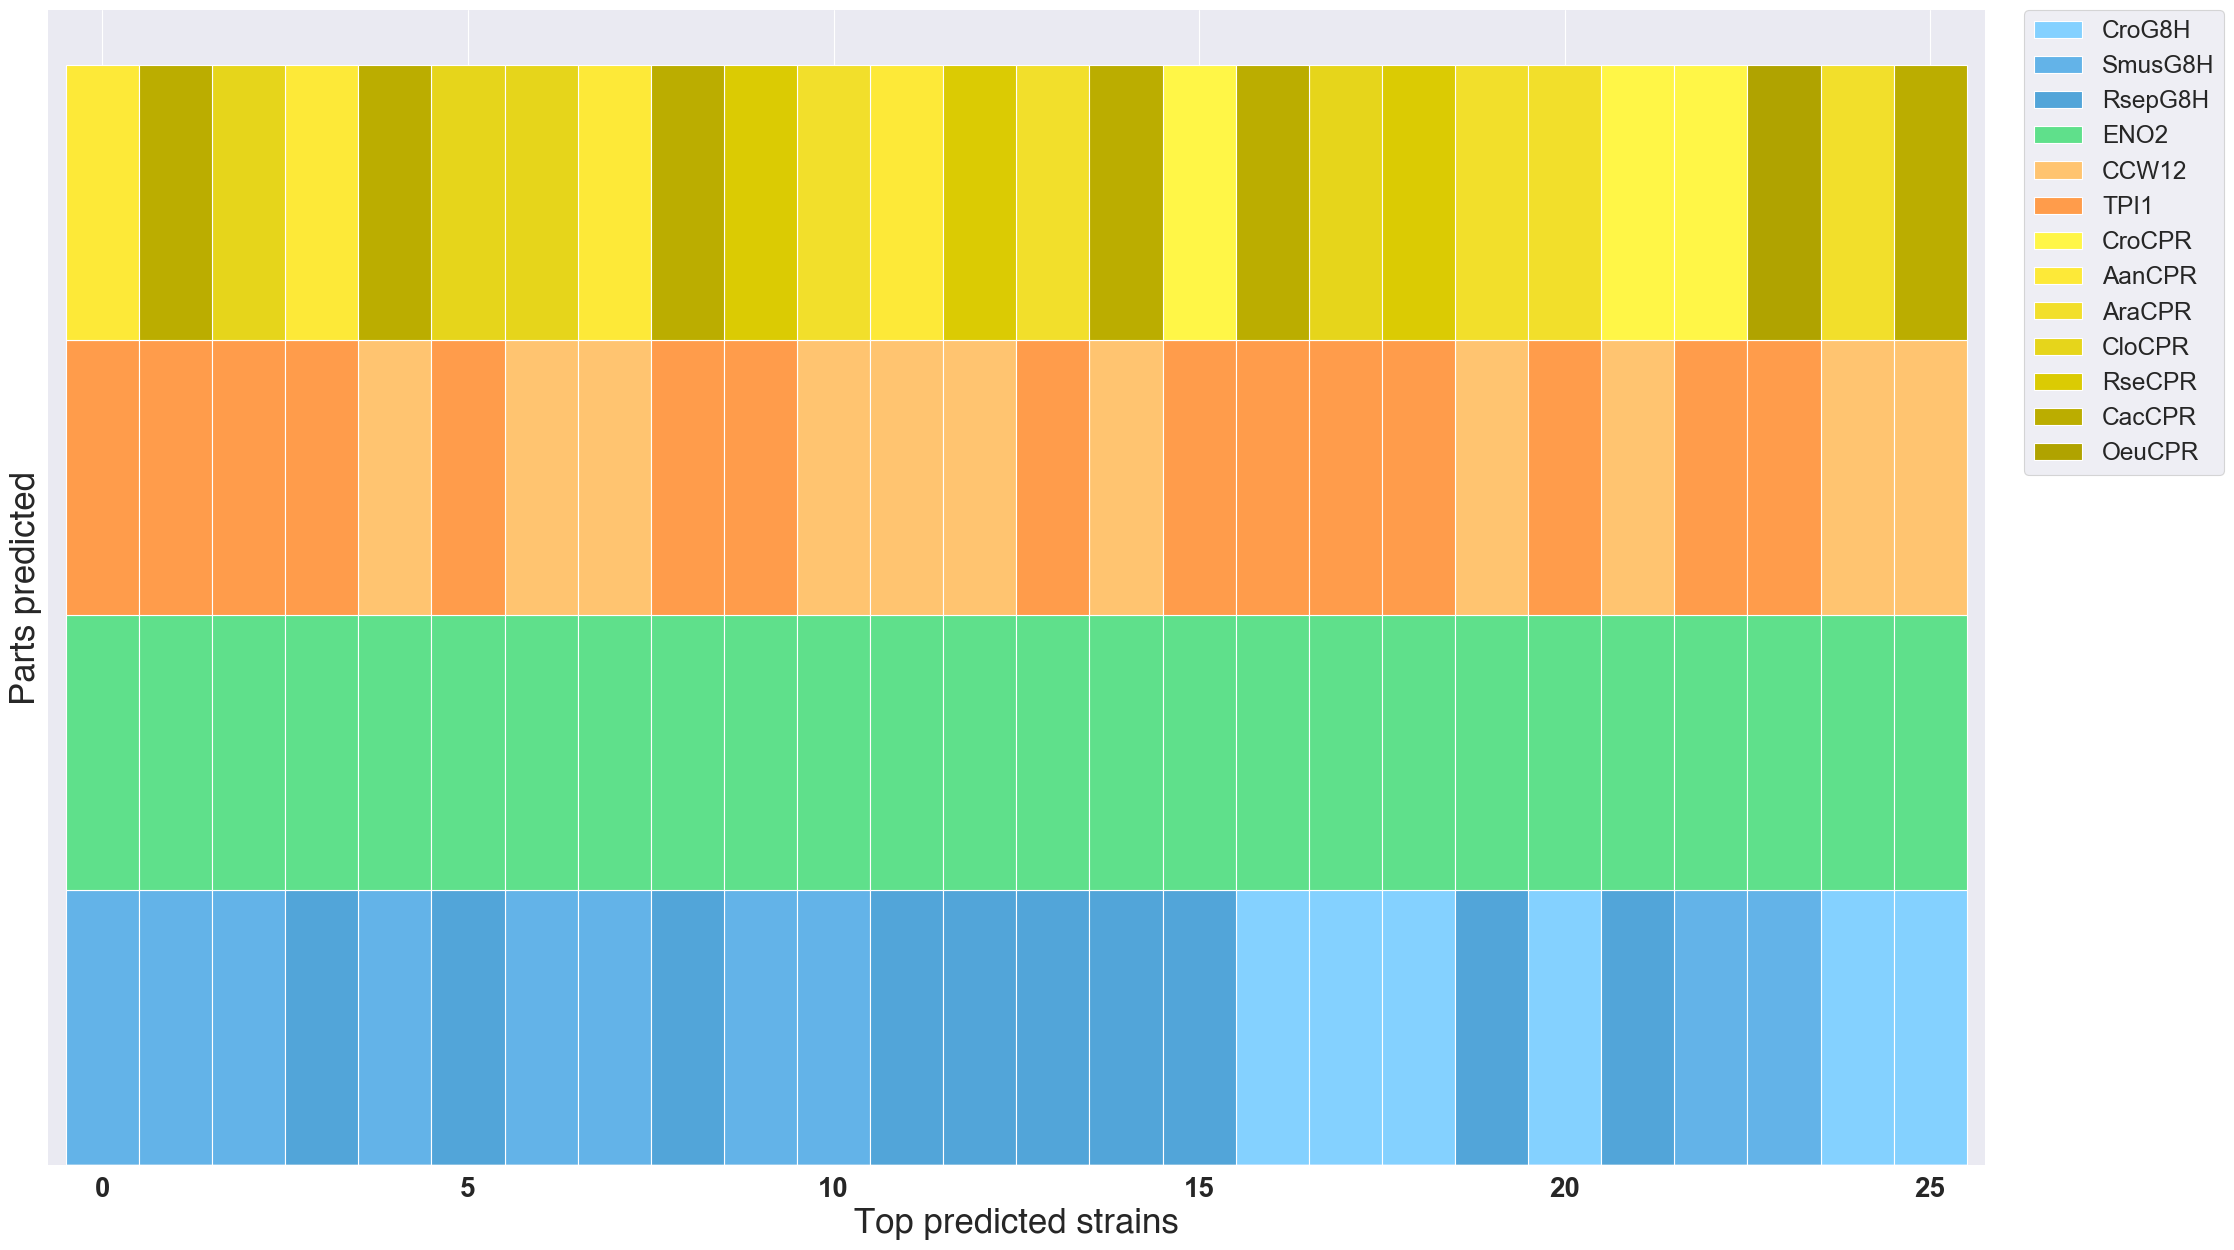

In [ ]:
ML2_recomendations100['Index'] = ML2_recomendations100.index
list_of_parts = []
parst_index = []

for index, row in ML2_recomendations100.iterrows():
    list_of_parts.append(row['G8H'])
    list_of_parts.append(row['pG8H'])
    list_of_parts.append(row['pCPR'])
    list_of_parts.append(row['CPR'])
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)


distribution = [25]*len(parst_index)

d = {'Index':parst_index,'Part':list_of_parts, 'Distribution':distribution }
df2 = pd.DataFrame(d)

# slice df
df200 = df2[:104]
cross_tab_prop = pd.crosstab(index=df200['Index'],
                             columns=df200['Part'])

coloumns = list(cross_tab_prop.columns)


print(len(cross_tab_prop))
# fix coloumns
coloumns = list(cross_tab_prop.columns)
fixed_columns = []
for name in all_parts:     
    if name in coloumns: 
        fixed_columns.append(name)

# get only the columns we use
cross_tab_prop = cross_tab_prop[fixed_columns]

name = 'Best_combinations_predicted_by_the_ML2_26_'
plot_stacked_barplot(cross_tab_prop, colorDict, save_pdf= True , path ='ConStrain_on_google_colab/data/10-plots/11_2_LEARN_Data_analysis/'+name, xlabel ='Top predicted strains' , ylabel = 'Parts predicted' ) 



## 6. Learning curve on data

In [28]:
from constrain.machine_learning.auto_ml import autoML_on_partitioned_data

To make sure we dont see the experimental differences between the different runs we can shuffle the data (see below)

In [30]:
shuffled_new_input_for_ml = new_input_for_ml.sample(frac=1, random_state= 1).reset_index(drop=True) # Random state sets a seed on the shuffeling
shuffled_new_input_for_ml

,Line_name,0,1,2,3,Amt_norm
0,yp53_A12,6,1,6,2,54.936173
1,yp53_F10,6,2,6,7,4.614405
2,yp53_F05,5,2,5,7,0.719111
3,yp49_A02,1,3,8,1,0.255578
4,yp53_A08,5,1,6,2,88.043986
...,...,...,...,...,...,...
291,yp50_G03,6,2,6,5,156.327285
292,yp49_B05,1,3,8,6,0.000000
293,yp50_C03,4,2,6,9,57.053306
294,yp49_F03,3,1,6,1,27.269807


In [31]:
feature_cols = ['0', '1', '2', '3']
training_column = 'Amt_norm'

# Training 5 partitions 3 times - the function is set to nfold = 10  by default. 
for i in range(0,3): 
    autoML_on_partitioned_data(feature_cols, training_column,
                               shuffled_new_input_for_ml,
                               training_time=0, 
                               partitions = 5,
                               nfold= 10,
                               path = 'ConStrain_on_google_colab/data/09-AutoML/learning_curve_data/second_round/0sec_experiment/NOT_shuffled/')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
09:30:45.429: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 60.0.

██████████████████████████████████████████████████████████████| (done) 100%
len of dataframes that are being trained on : 60
AutoML progress: |
10:31:04.8: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 120.0.

████████████████████████████████████████████████████████

### 6.1 - Visiualizing the learning curve

In [2]:
import os

# folder path
dir_path = 'ConStrain_on_google_colab/data/09-AutoML/learning_curve_data/second_round/nfold_10/0sec_experiment/shuffled_random1/'

# list file and directories
res = os.listdir(dir_path)
res

['.DS_Store',
 '2023_01_11_10:06_ml_models_running_over_partioned_data_df1_df2.csv',
 '2023_01_08_10:55_ml_models_running_over_partioned_data_df2_df1.csv',
 '2023_01_08_19:43_ml_models_running_over_partioned_data_df2_df1.csv',
 '2023_01_11_15:04_ml_models_running_over_partioned_data_df1_df2.csv',
 '2023_01_11_05:14_ml_models_running_over_partioned_data_df1_df2.csv',
 '2023_01_09_00:37_ml_models_running_over_partioned_data_df2_df1.csv']

In [3]:
lst_of_pd_dataframes = []
for ml_partitioned in res:
    if ml_partitioned.endswith('.csv'):
        lst_of_pd_dataframes.append(pd.read_csv(dir_path+ml_partitioned))

Lets retrieve the data 

In [4]:
dfs = [df.set_index('Unnamed: 0') for df in lst_of_pd_dataframes[3:]]
concated = pd.concat(dfs, axis=1)
concated

,0,CV_mean_MAE,CV_SD_MAE,Model_name,0,CV_mean_MAE,CV_SD_MAE,Model_name,0,CV_mean_MAE,CV_SD_MAE,Model_name
Unnamed: 0,,,,,,,,,,,,
60,20.265256,24.947948,11.087297,XGBoost_lr_search_selection_AutoML_26_20230111...,16.737130,20.445763,11.993407,StackedEnsemble_BestOfFamily_6_AutoML_16_20230...,7.428000,14.660718,7.493557,StackedEnsemble_BestOfFamily_7_AutoML_26_20230...
120,12.279735,18.538673,6.700190,StackedEnsemble_AllModels_5_AutoML_28_20230111...,12.173079,17.226658,9.652630,XGBoost_lr_search_selection_AutoML_17_20230111...,6.358275,12.685257,8.597869,XGBoost_lr_search_selection_AutoML_27_20230108...
180,10.961404,16.290192,4.917861,StackedEnsemble_BestOfFamily_7_AutoML_30_20230...,11.479273,14.279459,5.249099,StackedEnsemble_BestOfFamily_6_AutoML_18_20230...,9.702213,12.834663,4.162396,StackedEnsemble_AllModels_5_AutoML_28_20230108...
240,10.178009,15.006841,6.094630,GBM_grid_1_AutoML_32_20230111_130319_model_12,10.178009,15.006841,6.094630,GBM_grid_1_AutoML_19_20230111_31558_model_12,8.611914,12.872042,3.526086,XGBoost_lr_search_selection_AutoML_29_20230108...
296,10.048070,14.349804,4.571663,GBM_grid_1_AutoML_34_20230111_140339_model_12,10.119082,14.098402,4.570198,GBM_lr_annealing_selection_AutoML_20_20230111_...,9.448801,12.660960,3.520006,XGBoost_lr_search_selection_AutoML_30_20230108...


In [5]:

# test results
test_results = concated[['0']]
test_results['mean'] = test_results.mean(axis=1)
test_results['std'] = test_results.std(axis=1)
test_results

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_3059/2914699888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results['mean'] = test_results.mean(axis=1)
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_3059/2914699888.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results['std'] = test_results.std(axis=1)


,0,0,0,mean,std
Unnamed: 0,,,,,
60,20.265256,16.737130,7.428000,14.810129,5.415028
120,12.279735,12.173079,6.358275,10.270363,2.766606
180,10.961404,11.479273,9.702213,10.714297,0.746227
240,10.178009,10.178009,8.611914,9.655977,0.738264
296,10.048070,10.119082,9.448801,9.871984,0.300637


In [6]:

# Cross-validated mean MAE
cross_validated_results = concated[['CV_mean_MAE']]
cross_validated_results['mean'] = cross_validated_results.mean(axis=1)
cross_validated_results

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_3059/1005275068.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_validated_results['mean'] = cross_validated_results.mean(axis=1)


,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,mean
Unnamed: 0,,,,
60,24.947948,20.445763,14.660718,20.018143
120,18.538673,17.226658,12.685257,16.150196
180,16.290192,14.279459,12.834663,14.468105
240,15.006841,15.006841,12.872042,14.295241
296,14.349804,14.098402,12.660960,13.703055


In [7]:
# Cross-validated mean SD
cross_validated_results_sd = concated[['CV_SD_MAE']]
cross_validated_results_sd['mean'] = cross_validated_results_sd.mean(axis=1)
cross_validated_results_sd

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_3059/3504483626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_validated_results_sd['mean'] = cross_validated_results_sd.mean(axis=1)


,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,mean
Unnamed: 0,,,,
60,11.087297,11.993407,7.493557,10.191420
120,6.700190,9.652630,8.597869,8.316896
180,4.917861,5.249099,4.162396,4.776452
240,6.094630,6.094630,3.526086,5.238449
296,4.571663,4.570198,3.520006,4.220622


In [8]:
from constrain.plotting.plotting import plot_ml_learning_curve

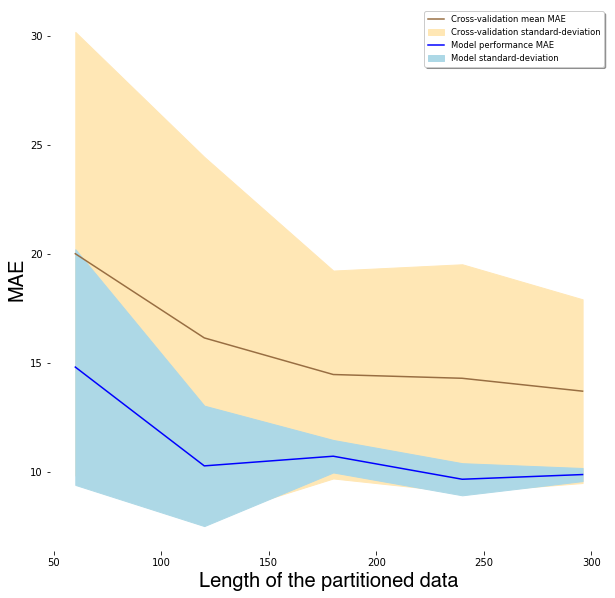

In [9]:
# CV
x = list(cross_validated_results.index)
y = list(cross_validated_results['mean'])
sd =  np.array(list(cross_validated_results_sd['mean']))

# model_performance
y1 = list(test_results['mean'])
sd1 = np.array(list(test_results['std']))

plot = plot_ml_learning_curve(x, y1, y,sd1,  sd, save_pdf = True , 
                              path = 'ConStrain_on_google_colab/data/10-plots/11_2_LEARN_Data_analysis/Learning_curve_on_partitioned_data_DBTL2_10_height_10_length.pdf', 
                             size_height = 10,
                             size_length = 10)

In [ ]:
h2o.shutdown()